In [6]:
# ===============================================
# 1. Import Library yang Dibutuhkan
# ===============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import os
import glob

In [9]:
# --- Import Library ---
import os, glob
import pandas as pd
from gdown import download_folder

# --- Download semua file dari shared folder Google Drive ---
FOLDER_ID = "1cNabqlUw8XsemmzQ8mdmMi_8uXOyTh84"
DATA_DIR = "data_raw"
os.makedirs(DATA_DIR, exist_ok=True)

download_folder(id=FOLDER_ID, output=DATA_DIR, quiet=True, use_cookies=False)

# --- Fungsi load dataset (pilih file csv/xlsx pertama yang valid) ---
def load_dataset_from_folder(folder_path: str) -> pd.DataFrame:
    paths = glob.glob(os.path.join(folder_path, "**/*.*"), recursive=True)
    for p in paths:
        ext = os.path.splitext(p)[1].lower()
        try:
            if ext == ".csv":
                df = pd.read_csv(p)
            elif ext == ".xlsx":
                df = pd.read_excel(p)
            else:
                continue
            print(f"Memuat dataset dari: {p} | shape={df.shape}")
            return df
        except Exception as e:
            print(f"Gagal membaca {p}: {e}")
            continue
    raise FileNotFoundError("Tidak ada file CSV/XLSX yang bisa dimuat.")

# --- Panggil fungsi load ---
df = load_dataset_from_folder(DATA_DIR)

# --- Preview dataset ---
df.head()
# --- Import Library ---
import os, glob
import pandas as pd
from gdown import download_folder

# --- Download semua file dari shared folder Google Drive ---
FOLDER_ID = "1cNabqlUw8XsemmzQ8mdmMi_8uXOyTh84"
DATA_DIR = "data_raw"
os.makedirs(DATA_DIR, exist_ok=True)

download_folder(id=FOLDER_ID, output=DATA_DIR, quiet=True, use_cookies=False)

# --- Fungsi load dataset (pilih file csv/xlsx pertama yang valid) ---
def load_dataset_from_folder(folder_path: str) -> pd.DataFrame:
    paths = glob.glob(os.path.join(folder_path, "**/*.*"), recursive=True)
    for p in paths:
        ext = os.path.splitext(p)[1].lower()
        try:
            if ext == ".csv":
                df = pd.read_csv(p)
            elif ext == ".xlsx":
                df = pd.read_excel(p)
            else:
                continue
            print(f"Memuat dataset dari: {p} | shape={df.shape}")
            return df
        except Exception as e:
            print(f"Gagal membaca {p}: {e}")
            continue
    raise FileNotFoundError("Tidak ada file CSV/XLSX yang bisa dimuat.")

# --- Panggil fungsi load ---
df = load_dataset_from_folder(DATA_DIR)

# --- Preview dataset ---
df.head()

Memuat dataset dari: data_raw/Salinan Salinan Online Retail Data.csv | shape=(461773, 7)
Memuat dataset dari: data_raw/Salinan Salinan Online Retail Data.csv | shape=(461773, 7)


,order_id,product_code,product_name,quantity,order_date,price,customer_id
0,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.50,12346.0
1,C493411,21539,RETRO SPOTS BUTTER DISH,-1,2010-01-04 09:43:00,4.25,14590.0
2,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,4.50,12346.0
3,493413,21724,PANDA AND BUNNIES STICKER SHEET,1,2010-01-04 09:54:00,0.85,NaN
4,493413,84578,ELEPHANT TOY WITH BLUE T-SHIRT,1,2010-01-04 09:54:00,3.75,NaN


In [10]:
# ===============================================
# 3. Data Cleaning
# ===============================================
# Buang baris dengan customer_id kosong karena tidak bisa digunakan untuk segmentasi
df = df.dropna(subset=['customer_id'])

# Ubah customer_id menjadi integer
df['customer_id'] = df['customer_id'].astype(int)

# Ubah order_date menjadi tipe datetime
df['order_date'] = pd.to_datetime(df['order_date'])

# Buang transaksi dengan quantity <= 0 atau harga <= 0 (data error)
df = df[(df['quantity'] > 0) & (df['price'] > 0)]

# Cek kembali
print(df.describe(include='all'))

       order_id product_code                        product_name  \
count    352897       352897                              352897   
unique    16757         3881                                4260   
top      500356       85123A  WHITE HANGING HEART T-LIGHT HOLDER   
freq        270         2866                                2866   
mean        NaN          NaN                                 NaN   
min         NaN          NaN                                 NaN   
25%         NaN          NaN                                 NaN   
50%         NaN          NaN                                 NaN   
75%         NaN          NaN                                 NaN   
max         NaN          NaN                                 NaN   
std         NaN          NaN                                 NaN   

             quantity                     order_date          price  \
count   352897.000000                         352897  352897.000000   
unique            NaN                    

In [11]:
# ===============================================
# 4. Feature Engineering (RFM)
# ===============================================
# Tentukan tanggal referensi (hari terakhir transaksi)
ref_date = df['order_date'].max() + pd.Timedelta(days=1)

# Buat tabel RFM
rfm = df.groupby('customer_id').agg({
    'order_date': lambda x: (ref_date - x.max()).days,   # Recency
    'order_id': 'nunique',                               # Frequency
    'price': lambda x: (x * df.loc[x.index, 'quantity']).sum()  # Monetary
}).reset_index()

rfm.columns = ['customer_id', 'Recency', 'Frequency', 'Monetary']

print(rfm.head())

   customer_id  Recency  Frequency  Monetary
0        12346      179          6    259.36
1        12608       54          1    415.79
2        12745      136          2    723.85
3        12746      190          1    254.55
4        12747       11         14   4396.24


In [12]:
# ===============================================
# 5. Normalisasi Data
# ===============================================
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

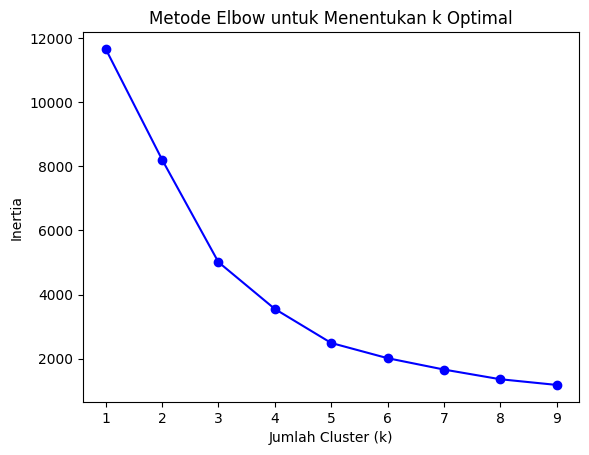

In [13]:
# ===============================================
# 6. Menentukan Jumlah Cluster (Elbow Method)
# ===============================================
inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, 'bo-')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia')
plt.title('Metode Elbow untuk Menentukan k Optimal')
plt.show()

In [14]:
# ===============================================
# 7. Clustering dengan KMeans
# ===============================================
# Misalkan kita pilih k=4 dari grafik elbow
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

print(rfm.groupby('Cluster').mean())

          customer_id     Recency  Frequency       Monetary
Cluster                                                    
0        15548.581466   50.146640   4.438221    1633.367382
1        15608.102564  235.370123   1.571906     520.924039
2        18102.000000   15.000000  80.000000  308158.610000
3        15433.558140   12.976744  50.976744   33353.938209


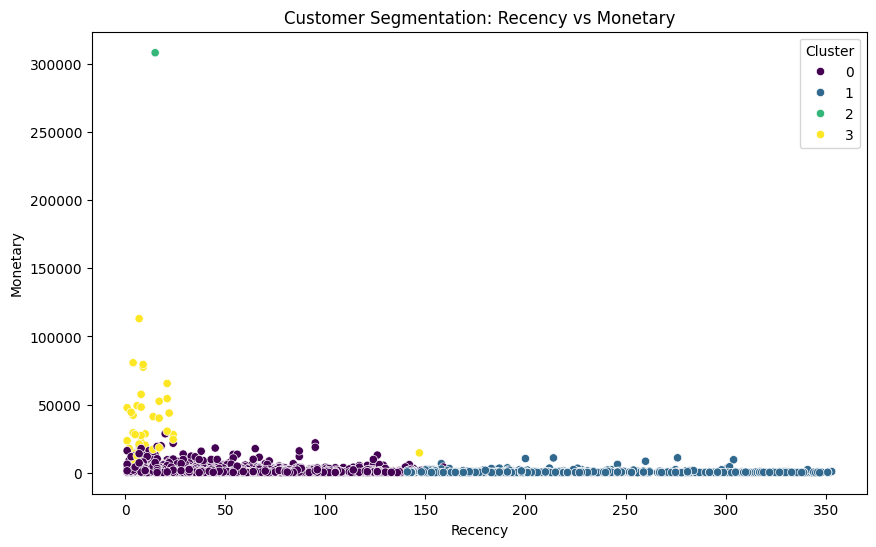

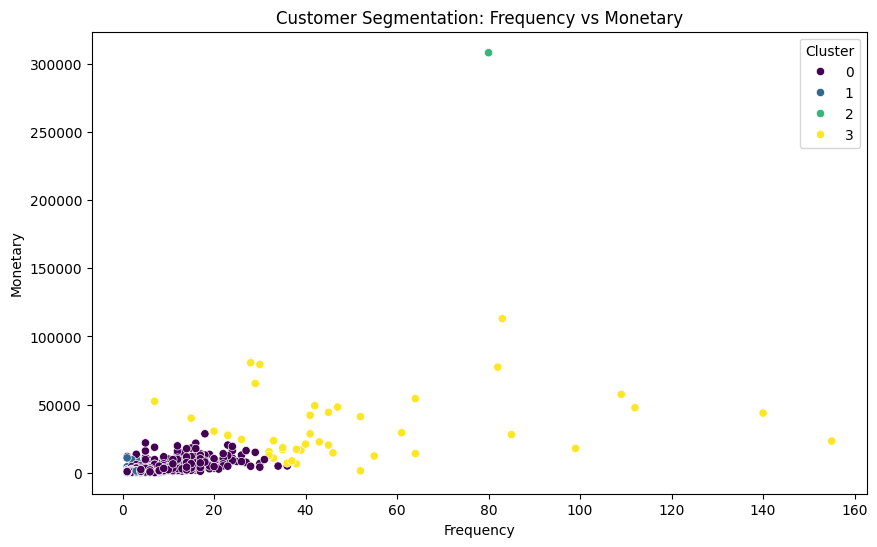

In [15]:
# ===============================================
# 8. Visualisasi Cluster
# ===============================================
plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm, x="Recency", y="Monetary", hue="Cluster", palette="viridis")
plt.title("Customer Segmentation: Recency vs Monetary")
plt.show()

plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm, x="Frequency", y="Monetary", hue="Cluster", palette="viridis")
plt.title("Customer Segmentation: Frequency vs Monetary")
plt.show()

In [16]:
# --- Hitung RFM ---
ref_date = df['order_date'].max() + pd.Timedelta(days=1)
rfm = df.groupby('customer_id').agg({
    'order_date': lambda x: (ref_date - x.max()).days,   # Recency
    'order_id': 'nunique',                               # Frequency
    'price': lambda x: (x * df.loc[x.index, 'quantity']).sum()  # Monetary
}).reset_index()

rfm.columns = ['customer_id', 'Recency', 'Frequency', 'Monetary']

# --- Skor RFM (1-5) ---
rfm['R_Score'] = pd.qcut(rfm['Recency'], 5, labels=[5,4,3,2,1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method="first"), 5, labels=[1,2,3,4,5])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 5, labels=[1,2,3,4,5])

rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score','F_Score','M_Score']].astype(int).sum(axis=1)

# --- Mapping Segment ---
seg_map = {
    r'[5][4-5][4-5]': '01-Champion',
    r'[4-5][2-3][3-5]': '02-Loyal Customers',
    r'[3-4][4-5][1-3]': '03-Potential Loyalists',
    r'[1-2][4-5][4-5]': "04-Can't Lose Them",
    r'[3-4][2-3][1-2]': '05-Need Attention',
    r'[5][1][1]': '06-New Customers',
    r'[4][1-2][1-2]': '07-Promising',
    r'[1-2][2-3][2-3]': '08-At Risk',
    r'[2-3][1][1]': '09-About to Sleep',
    r'[1][1][1]': '10-Hibernating'
}

rfm['Segment'] = 'Others'
for pattern, segment in seg_map.items():
    rfm.loc[rfm['RFM_Segment'].str.match(pattern), 'Segment'] = segment

# --- Summary Statistik per Segment ---
summary = rfm.groupby('Segment').agg(
    customer_count=('customer_id','count'),
    recency_mean=('Recency','mean'),
    recency_median=('Recency','median'),
    freq_mean=('Frequency','mean'),
    freq_median=('Frequency','median'),
    monetary_mean=('Monetary','mean'),
    monetary_median=('Monetary','median')
).reset_index()

# hitung persentase
total_cust = summary['customer_count'].sum()
summary['percent'] = 100 * summary['customer_count'] / total_cust

# --- Urutkan berdasarkan nama segment ---
summary = summary.sort_values('Segment')

print(summary)

                   Segment  customer_count  recency_mean  recency_median  \
0              01-Champion             538     12.500000            12.0   
1       02-Loyal Customers             225     24.942222            25.0   
2   03-Potential Loyalists             150     44.346667            40.0   
3       04-Can't Lose Them             183    122.005464           106.0   
4        05-Need Attention             205     54.087805            56.0   
5         06-New Customers              18     15.833333            18.0   
6             07-Promising             159     33.729560            33.0   
7               08-At Risk             408    174.056373           154.0   
8        09-About to Sleep             151     89.205298            82.0   
9           10-Hibernating             185    259.443243           261.0   
10                  Others            1665    101.440240            67.0   

    freq_mean  freq_median  monetary_mean  monetary_median    percent  
0   13.198885  

---

# Customer Segmentation Analysis (RFM)

## Insight per Segmentasi

### 1. 01-Champion (538 pelanggan, 13.8%)

* Recency rendah (±12 hari) → baru saja berbelanja.
* Frequency cukup tinggi (±13 transaksi).
* Monetary sangat tinggi (± Rp 6.5 juta).
  **Insight:** Pelanggan paling berharga (VIP). Harus dipertahankan dengan reward, personalisasi, atau program loyalitas eksklusif.

---

### 2. 02-Loyal Customers (225 pelanggan, 5.8%)

* Recency relatif rendah (25 hari).
* Frequency rendah (2–3 transaksi).
* Monetary cukup rendah (± Rp 1 juta).
  **Insight:** Setia, tetapi pembelian kecil. Perlu strategi upselling atau bundling produk.

---

### 3. 03-Potential Loyalists (150 pelanggan, 3.8%)

* Recency sekitar 44 hari.
* Frequency sedang (±4 transaksi).
* Monetary masih rendah (± Rp 700 ribu).
  **Insight:** Berpotensi menjadi loyal bila diberi promosi khusus atau membership.

---

### 4. 04-Can't Lose Them (183 pelanggan, 4.7%)

* Recency tinggi (±122 hari).
* Frequency tinggi (±6 transaksi).
* Monetary besar (± Rp 2.6 juta).
  **Insight:** Pelanggan bernilai tinggi yang hampir hilang. Butuh strategi win-back (diskon personal, reminder, campaign email).

---

### 5. 05-Need Attention (205 pelanggan, 5.2%)

* Recency sedang (54 hari).
* Frequency rendah (±2 transaksi).
* Monetary rendah (± Rp 290 ribu).
  **Insight:** Mulai jarang aktif. Perlu engagement campaign agar tidak pindah ke kompetitor.

---

### 6. 06-New Customers (18 pelanggan, 0.46%)

* Recency sangat rendah (±16 hari).
* Frequency = 1, Monetary masih rendah.
  **Insight:** Pelanggan baru. Harus diberi pengalaman terbaik agar kembali berbelanja.

---

### 7. 07-Promising (159 pelanggan, 4.0%)

* Recency 33 hari.
* Frequency rendah (1 kali).
* Monetary rendah (± Rp 250 ribu).
  **Insight:** Masih coba-coba. Perlu promosi “Buy Again” agar cepat jadi loyal.

---

### 8. 08-At Risk (408 pelanggan, 10.5%)

* Recency tinggi (±174 hari).
* Frequency rendah (±2 transaksi).
* Monetary menengah (± Rp 500 ribu).
  **Insight:** Sudah jarang aktif. Perlu re-activation campaign (voucher ulang tahun, email reminder, limited offer).

---

### 9. 09-About to Sleep (151 pelanggan, 3.9%)

* Recency 89 hari.
* Frequency sangat rendah (1 transaksi).
* Monetary rendah (± Rp 140 ribu).
  **Insight:** Hampir tidak aktif. Perlu campaign segera.

---

### 10. 10-Hibernating (185 pelanggan, 4.7%)

* Recency sangat tinggi (±259 hari).
* Frequency sangat rendah (1 transaksi).
* Monetary rendah (± Rp 137 ribu).
  **Insight:** Tidak aktif lagi. Hampir masuk kategori churn.

---

### 11. Others (1665 pelanggan, 42.8%)

* Recency rata-rata 101 hari.
* Frequency moderat (±3.5 transaksi).
* Monetary cukup tinggi (± Rp 1.39 juta).
  **Insight:** Banyak pelanggan tidak terklasifikasi ke segmen utama. Perlu refinement RFM atau segmentasi tambahan (misalnya berdasarkan kategori produk).

---

## Kesimpulan Strategis

1. **High-Value Customer (Champions & Loyal):** ±20% pelanggan dengan kontribusi revenue terbesar. Harus diprioritaskan dengan program loyalitas.
2. **At-Risk & Can't Lose Them:** ±15% pelanggan bernilai tinggi yang mulai tidak aktif. Perlu campaign retensi segera.
3. **New, Promising, Potential Loyalists:** ±8% pelanggan yang berpotensi tumbuh nilainya melalui upselling dan engagement.
4. **Hibernating & About to Sleep:** ±9% pelanggan hampir churn. Campaign retensi mungkin mahal, perlu dipertimbangkan ROI.
5. **Others:** 42.8% pelanggan masuk kategori abu-abu. Perlu segmentasi tambahan atau tuning model RFM.

---

